In [1]:
import math
import numpy as np
import numpy.random as npr
from numpy import linalg
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset
import torch.optim as optim
import time
from useful_tools import isPointinPolygon,polyshow,Genpoint,Distance_pol,GenBC
from network import ResNet
from math import *
torch.cuda.set_device(0)

In [2]:
def sol_exact(x):
    return torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
def sol_exact_H1(x):
    sol = torch.zeros(x.shape[0],3).cuda()
    sol[:,0:1] = torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
    sol[:,1:3] = pi*torch.cos(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
    return sol

In [3]:
def right(x):
    return -2*pi**2*torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)

In [4]:
dim_set = 2
Batch_size = 50000
def DGM1():
    x = torch.rand(Batch_size,2).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    r = model_r(x)
    v= torch.ones(u.shape).cuda()
    ux = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    loss1 = torch.sum((ux-du)**2)/Batch_size+torch.sum((r-u-du)**2)/Batch_size
    return loss1

In [5]:
def DGM2():
    x = torch.rand(Batch_size,dim_set).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    v= torch.ones(u.shape).cuda()
    uxx = torch.zeros(Batch_size,dim_set).cuda()
    for i in range(dim_set):
        ux_tem = du[:,i].reshape([x.size()[0],1])
        uxx_tem = torch.autograd.grad(ux_tem,x,grad_outputs=v,create_graph=True)[0]
        uxx[:,i] = uxx_tem[:,i]
    loss2 = torch.sum((torch.sum(uxx,dim=1).reshape([x.size()[0],1]) - right(x))**2)/Batch_size
    return loss2

In [6]:
model_u = ResNet(dim_set,5,1)
model_r1 = ResNet(dim_set,5,dim_set)

device=torch.device("cuda:0" )
model_u.to(device)
model_r1.to(device)

ResNet(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=5, bias=True)
  (outlayer): Linear(in_features=5, out_features=2, bias=True)
)

In [7]:
def model_r(x):
    return x*(1-x)*model_r1(x) + torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1) + pi * torch.cos(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)

In [8]:
def model_p(x):
    return model_r(x)-model_u(x)

In [9]:
def loss_error():
    notes_error = torch.rand(10000,dim_set).cuda()
    notes_error.requires_grad= True
    exact = sol_exact_H1(notes_error)
    u_L2 = sqrt(torch.sum((exact[:,0])**2)/10000)
    Du_L2 = sqrt(torch.sum(exact[:,1:dim_set+1]**2)/10000)
    predict = torch.zeros(10000,2*dim_set+2).cuda()
    predict[:,0]= model_u(notes_error).reshape([1,notes_error.size()[0]])
    predict[:,1:dim_set+1]= model_p(notes_error)
    value1 = sqrt(torch.sum((predict[:,0] - exact[:,0])**2)/10000)/u_L2
    value2 = sqrt(torch.sum((predict[:,1:dim_set+1] - exact[:,1:dim_set+1])**2)/10000)/Du_L2
    return value1,value2

In [10]:
traintime = 20000
error_save=np.zeros([2,traintime])
optimizer = optim.Adam([
                {'params': model_r1.parameters()},
                {'params': model_u.parameters()}
            ])
i = 0
time_start=time.time()
for i in range(traintime):
    optimizer.zero_grad()
    losses = DGM1()+DGM2()
    losses.backward()
    optimizer.step() 
    error1,error2 = loss_error()
    error_save[0,i]=float(error1)
    error_save[1,i]=float(error2)
    i = i +1
    if i%500==1:
        print("i= ",i)
        print("error =",error1)
        print("loss1 =",losses.detach())
        np.save("error_save_LDG_Robin_2D_w5.npy", error_save)
np.save("error_save_LDG_Robin_2D_w5.npy", error_save)
time_end=time.time()
print('time cost',time_end-time_start,'s')

i=  1
error = 0.9471593347227287
loss1 = tensor(27.6166, device='cuda:0')
i=  501
error = 0.5734457871620938
loss1 = tensor(0.9628, device='cuda:0')
i=  1001
error = 0.10765083814955327
loss1 = tensor(0.1130, device='cuda:0')
i=  1501
error = 0.05019129454318565
loss1 = tensor(0.0530, device='cuda:0')
i=  2001
error = 0.03939393657775342
loss1 = tensor(0.0354, device='cuda:0')
i=  2501
error = 0.03235435186083299
loss1 = tensor(0.0284, device='cuda:0')
i=  3001
error = 0.027192564896834238
loss1 = tensor(0.0207, device='cuda:0')
i=  3501
error = 0.021158152903650924
loss1 = tensor(0.0145, device='cuda:0')
i=  4001
error = 0.016176621491980174
loss1 = tensor(0.0076, device='cuda:0')
i=  4501
error = 0.009871278039731951
loss1 = tensor(0.0055, device='cuda:0')
i=  5001
error = 0.013684173928778564
loss1 = tensor(0.0093, device='cuda:0')
i=  5501
error = 0.019913235440054945
loss1 = tensor(0.0091, device='cuda:0')
i=  6001
error = 0.015882839985038064
loss1 = tensor(0.0065, device='cuda:0

In [11]:
import matplotlib.pyplot as plt
x = np.arange(0,1,0.01)
notes= torch.rand(100,2).cuda()
notes[:,0:1] = 1
notes[:,1] = torch.tensor(x)

In [12]:
u_e = sol_exact_H1(notes)[:,0:1]
p_e = sol_exact_H1(notes)[:,1:3]

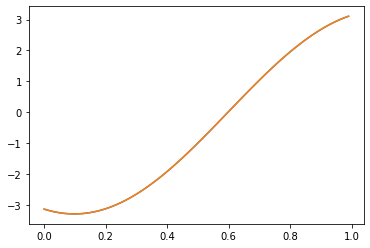

In [13]:
plt.plot(x,(u_e+p_e).cpu().detach().numpy())

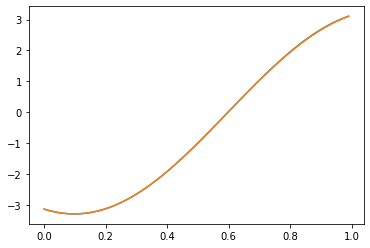

In [14]:
u =  model_u(notes)
p =  model_p(notes)
r =  model_r(notes)
plt.plot(x,(r).cpu().detach().numpy())